In [96]:
import os
import sys
import math

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import rotate, shift
from scipy.ndimage.morphology import binary_erosion, binary_opening, binary_closing

from skimage.measure import block_reduce

from skimage.transform import hough_line, hough_line_peaks

import os 
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
from sklearn.decomposition.pca import PCA

In [97]:
def binarize(img, thres):
    res = np.sum(img,axis=2) > thres
    return res.astype(int)

def downsample(img):
    res = block_reduce(img, block_size=(21, 21), func=np.mean)
    return res

def erode(img):
    res = binary_erosion(img, np.ones((3,3), dtype=np.int))
    return res

def find_angle(img):
    img = binarize(img, 2)
    img = downsample(img)
    img = erode(img)
    h_space, angles, dist = hough_line(img)
    h_space, angles, dist = hough_line_peaks(h_space, angles, dist, num_peaks=1)
    return math.degrees(angles[0])

def rotate_to_base(img):
    """
    Finds out what the asparagus angle is, zeroes image by rotating it to 0°, then creates 
    three +/- 5° rotations of it, with noise added to the degrees by which the image is rotated
    """
    angle = find_angle(img)
    base = rotate(img, -1*angle, reshape=False, mode="constant")
    return base



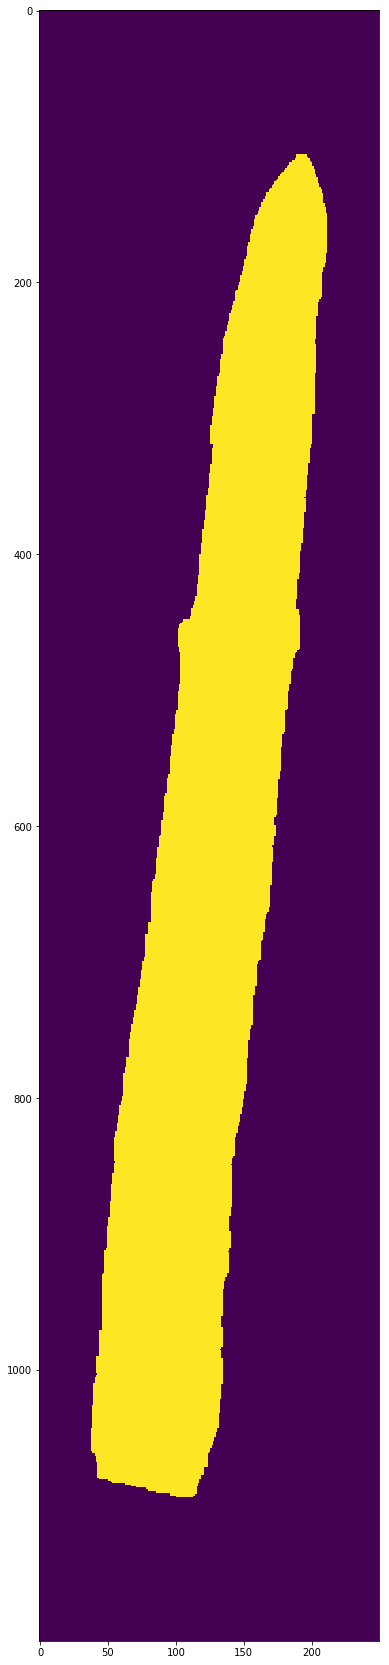

In [105]:
import sys
import numpy
#numpy.set_printoptions(threshold=sys.maxsize)

from skimage.measure import label, regionprops
img = plt.imread("/Users/thomasklein/Uni/8. Semester/asparagus/images/test/2_1.jpg")

def mask(img):
    """
    Finds asparagus in an image and returns a mask that is 1 for every pixel which belongs
    to an asparagus piece and 0 everywhere else. 
    
    img = the image after running segmentation based on color
    
    returns: mask as described above
    """
    img = np.array(img)
    bin_img = binarize(img, 10)
    
    def find_largest_region(binary_img):
        """
        Finds the largest continuous region in a binary image
        (which hopefully is the asparagus piece)
        
        binary_img = a binary image with patches of different sizes
        
        returns: essentially a mask
        """
        labeled_img = label(bin_img)
        props = regionprops(labeled_img)
        maxi = 0
        maxval = 0
        for i, prop in enumerate(props):
            if prop.area > maxval:
                maxi = i
                maxval = prop.area

        proppy = props[maxi]
        coords = proppy.coords # 2d np array
        empty = np.zeros(bin_img.shape)
        for i in range(len(coords)):
            empty[coords[i,0], coords[i,1]] = 1
        return empty
    
    # find largest region, open the image, and find the largest region
    # once again, because the opening might just have created a small
    # "island" instead of completely removing the noise
    empty = find_largest_region(bin_img)
    empty = binary_opening(empty, structure=np.ones((8,8)))
    empty = find_largest_region(empty)
    
    return empty


plt.figure(figsize=(30,30))
plt.imshow(empty)
plt.show()




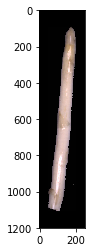

(1035, 80)


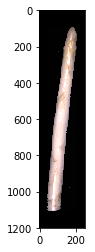

(3, 76)


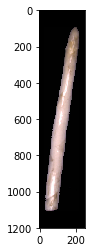

(8, 74)


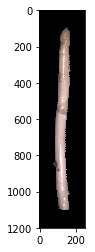

(1, 93)


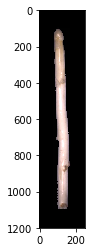

(1006, 98)


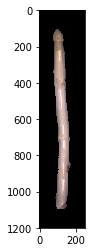

(1006, 98)


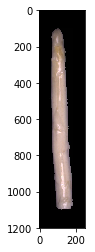

(4, 97)


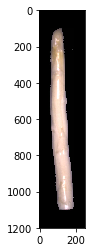

(1011, 94)


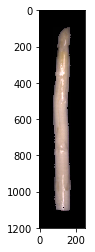

(2, 79)


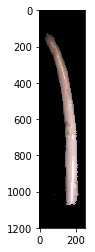

(4, 104)


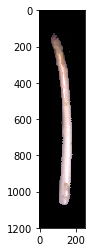

(5, 116)


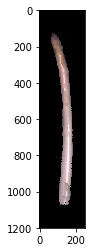

(2, 116)


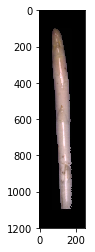

(1005, 98)


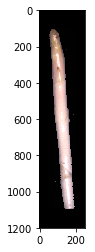

(1001, 99)


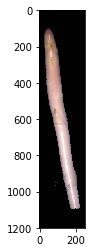

(1011, 94)


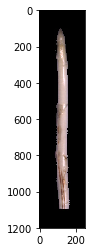

(1, 96)


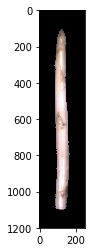

(4, 96)


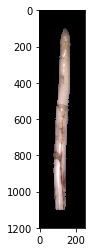

(1012, 94)


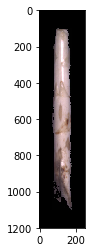

(1006, 95)


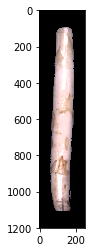

(3, 78)


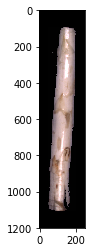

(3, 79)


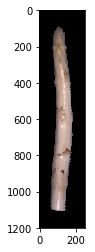

(2, 80)


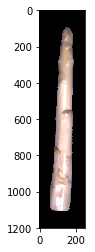

(4, 79)


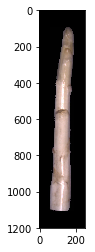

(3, 78)


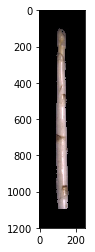

(1009, 96)


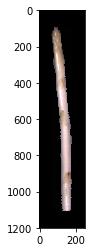

(2, 83)


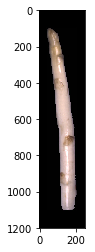

(1017, 91)


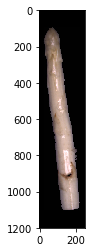

(1021, 89)


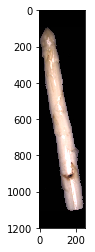

(1026, 87)


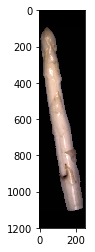

(1030, 85)


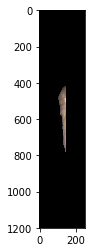

(1, 415)


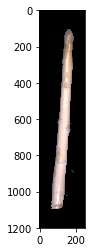

(1013, 94)


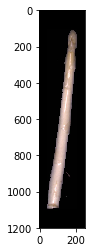

(2, 92)


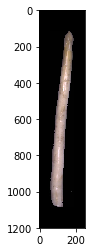

(981, 109)


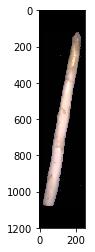

(982, 109)


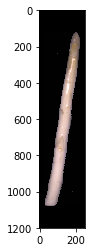

(977, 111)


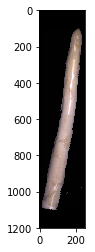

(1022, 89)


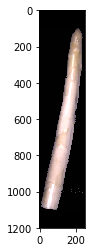

(1022, 89)


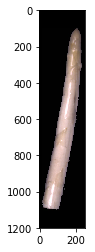

(1023, 89)


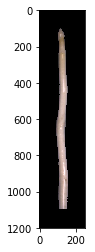

(2, 96)


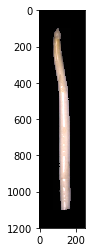

(1009, 96)


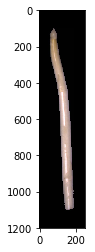

(1010, 95)


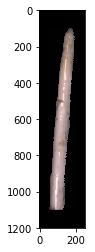

(1017, 92)


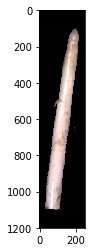

(1021, 90)


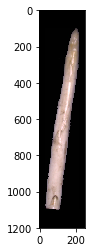

(1, 89)


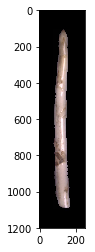

(2, 96)


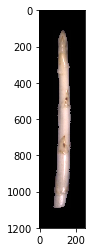

(4, 97)


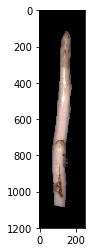

(1, 110)


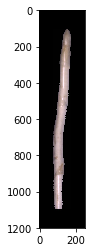

(4, 95)


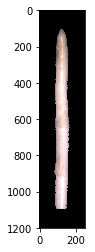

(1009, 96)


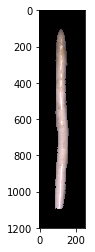

(1008, 96)


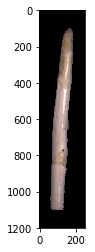

(4, 93)


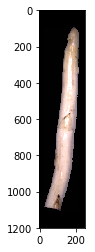

(1, 83)


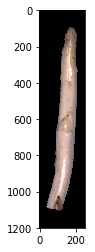

(2, 76)


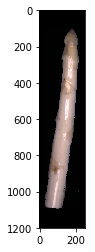

(1008, 95)


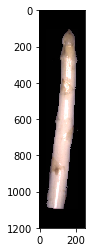

(1005, 98)


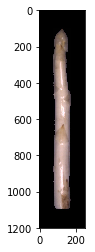

(1009, 96)


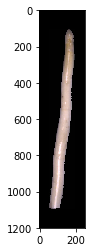

(2, 98)


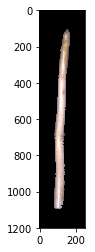

(3, 97)


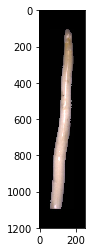

(1012, 95)


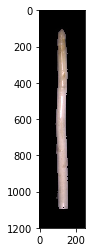

(2, 96)


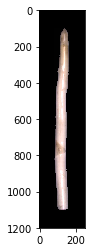

(1009, 96)


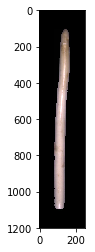

(1011, 95)


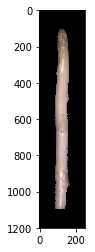

(1, 96)


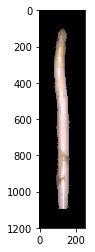

(3, 96)


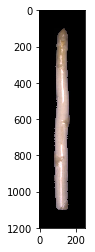

(2, 95)


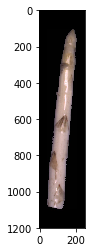

(3, 93)


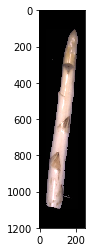

(1003, 98)


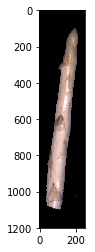

(1016, 90)


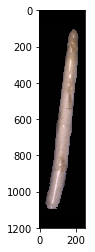

(4, 90)


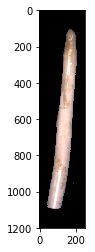

(2, 92)


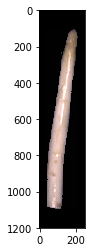

(5, 90)


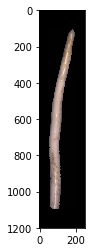

(4, 93)


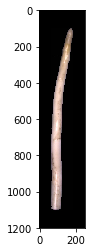

(1014, 93)


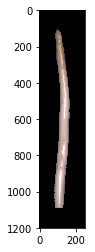

(1005, 99)


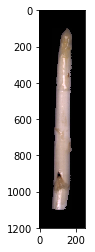

(1013, 94)


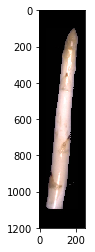

(4, 90)


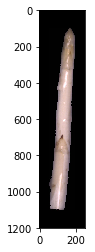

(1, 93)


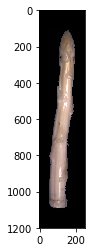

(2, 96)


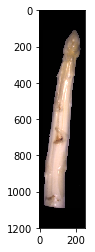

(1002, 99)


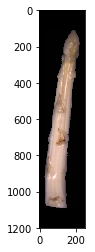

(1002, 99)


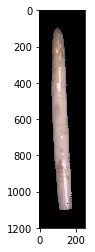

(1014, 93)


KeyboardInterrupt: 

In [33]:
from scipy.ndimage import label, find_objects

def get_length(img):
    '''Simple length extraction
    The length is measured from the highest white pixel to the lowest in the binarized image after rotation
    Args:
        img: the image
    Returns:
        length: the length from highest to lowest white pixel
        min_row: the row of the highest pixel
    '''
    # rotate the image so that it is upright
    img_rotated = rotate_to_base(img)#verticalize_img(img)
    img = binarize(img_rotated, 0)
    # use Thomas helper functions to get the boolean image
    #img_mask = filter_mask_img(binarize_asparagus_img(img_rotated))
    # set labels to the different areas, which are in our case only two - background and asparagus
    img_labeled, _ = label(img)
    # regionprops extracts all kinds of features from the labeld image
    box = find_objects(img_labeled)#measure.regionprops(img_labeled)
    # we only need the properties from the bounding box
    hs, ws = box[0]
    length = hs.stop - hs.start
    #min_row, _, max_row, _ = props[0].bbox
    # finally we can calculate the length by subtracting the min from the max pixel position
    #length = max_row - min_row
    
    return length, hs.start



img_dir ="../../images/test/"
for subdir, dirs, files in os.walk(img_dir):
    for file in sorted([f for f in files if f[-4:]==".jpg"]):
        img = plt.imread(os.path.join(subdir, file))
        length, min_row = get_length(img)
        plt.imshow(img)
        plt.show()
        print(get_length(img))